In [60]:
import kagglehub
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from linearmodels import PanelOLS, RandomEffects
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
from stargazer.stargazer import Stargazer
from scipy.stats import chi2
import os

pd.options.display.float_format = '{:.2f}'.format

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

Neyman_Orthogonality_Proof.md
    - DML_Algorithm_Steps.md         <-- スクラッチ実装の設計図.  
    - CATE_vs_ATE.md.
末石本（ATEとLATE）.  
GMMの直行条件→ネイマン直交→その他学習者（SとかTとか）→DML.  

ロードマップ:4章（行列表記と漸近理論）→3章（ATEとLATE）→5章（GMM）→論文（導出・理解(CATE・ネイマン直交・SとかTラーナー・DML)）→論文（実装）.  
5章（GMM）→論文（導出・理解(CATE・ネイマン直交・SとかTラーナー・DML)）→論文（実装）

Lasso

フリッシュ＝ウォー＝ロベル（FWL）定理

In [61]:
path = kagglehub.dataset_download("fronkongames/steam-games-dataset")

print("保存先パス:", path)

csv_path = os.path.join(path, "games.csv")

df = pd.read_csv(csv_path, index_col=False, quotechar='"')
df.head()

保存先パス: /Users/kavuk/.cache/kagglehub/datasets/fronkongames/steam-games-dataset/versions/31


AppID                                   Name  Release date  \
0  2539430             Black Dragon Mage Playtest   Aug 1, 2023   
1   496350  Supipara - Chapter 1 Spring Has Come!  Jul 29, 2016   
2  1034400      Mystery Solitaire The Black Raven   May 6, 2019   
3  3292190            버튜버 파라노이아 - Vtuber Paranoia  Oct 31, 2024   
4  3631080                          Maze Quest VR  Apr 24, 2025   

  Estimated owners  Peak CCU  Required age  Price  DiscountDLC count  \
0            0 - 0         0             0   0.00                  0   
1        0 - 20000         0             0   5.24                 65   
2        0 - 20000         0             0   4.99                  0   
3        0 - 20000         1             0   8.99                  0   
4        0 - 20000         0             0   4.99                  0   

   About the game                                Supported languages  \
0               0                                                NaN   
1               0  Springtime, April: when the cherry trees come ...   
2               0  Immerse yourself in the most beloved, mystical...   
3               1  synopsis 'Hello, I'm Hiyoro, a new YouTuber!' ...   
4               0  Its not just a Maze; its a Quest! Enter the ca...   

                         Full audio languages      Reviews Header image  \
0                                          []           []          NaN   
1                                 ['English']           []          NaN   
2  ['English', 'French', 'German', 'Russian']           []          NaN   
3                                  ['Korean']   ['Korean']          NaN   
4                                 ['English']  ['English']          NaN   

                                             Website  \
0  https://shared.akamai.steamstatic.com/store_it...   
1  https://shared.akamai.steamstatic.com/store_it...   
2  https://shared.akamai.steamstatic.com/store_it...   
3  https://shared.akamai.steamstatic.com/store_it...   
4  https://shared.akamai.steamstatic.com/store_it...   

                                   Support url  \
0                                          NaN   
1               http://mangagamer.org/supipara   
2        https://www.facebook.com/8FloorGames/   
3                                          NaN   
4  https://www.realityexpanded.com/books-games   

                          Support email                      Windows   Mac  \
0                                   NaN                          NaN  True   
1                 http://mangagamer.com       support@mangagamer.com  True   
2  https://www.facebook.com/8FloorGames           support@8floor.net  True   
3                                   NaN        yujingamesc@gmail.com  True   
4       https://www.realityexpanded.com  support@realityexpanded.com  True   

   Linux  Metacritic score  Metacritic url User score  Positive  Negative  \
0  False             False               0        NaN         0         0   
1  False             False               0        NaN         0       252   
2   True             False               0        NaN         0        21   
3  False             False               0        NaN         0         0   
4  False             False               0        NaN         0         0   

   Score rank  Achievements  Recommendations  Notes  \
0           0           NaN                0      0   
1           3           NaN                0    231   
2           3           NaN                0      0   
3           0           NaN               19      0   
4           0           NaN                0      0   

                            Average playtime forever  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3  The game includes the following elements. 1. G...   
4                                                NaN   

   Average playtime two weeks  Median playtime 

In [62]:
# 1. 'DiscountDLC count' を 2つに分ける（もし中身が混ざっているなら）
# もし単に名前が間違っているだけなら、rename でOK
df = df.rename(columns={'DiscountDLC count': 'Discount'})

# 2. 特徴量として使わなさそうな「画像」や「URL」を削る（DMLのSELECT的な操作）
drop_cols = ['Header image', 'Website', 'Support url', 'Support email', 'Metacritic url']
df_clean = df.drop(columns=drop_cols)

# 3. 欠損値（NaN）の処理
df_clean = df_clean.dropna(subset=['Price', 'Peak CCU'])

# スペースをアンダースコアに置換
df.columns = [c.replace(' ', '_') for c in df.columns]

In [63]:
df['nega_notes_ratio'] = df['Negative'] / (df['Notes'] + 1)
df['log_ccu'] = np.log(df['Peak_CCU'] + 1)
df['log_negative'] = np.log(df['Negative'] + 1)
df['log_notes'] = np.log(df['Notes'] + 1)
df['log_median_playtime'] = np.log1p(df['Median_playtime_forever'])

In [64]:
print(df.columns)

Index(['AppID', 'Name', 'Release_date', 'Estimated_owners', 'Peak_CCU',
       'Required_age', 'Price', 'Discount', 'About_the_game',
       'Supported_languages', 'Full_audio_languages', 'Reviews',
       'Header_image', 'Website', 'Support_url', 'Support_email', 'Windows',
       'Mac', 'Linux', 'Metacritic_score', 'Metacritic_url', 'User_score',
       'Positive', 'Negative', 'Score_rank', 'Achievements', 'Recommendations',
       'Notes', 'Average_playtime_forever', 'Average_playtime_two_weeks',
       'Median_playtime_forever', 'Median_playtime_two_weeks', 'Developers',
       'Publishers', 'Categories', 'Genres', 'Tags', 'Screenshots', 'Movies',
       'nega_notes_ratio', 'log_ccu', 'log_negative', 'log_notes',
       'log_median_playtime'],
      dtype='object')


In [65]:
df.sample(n=15)

AppID                                               Name  \
71256   1481680                                 Lab Craft Survival   
114755  2926180  City Legends: The Witness in the Rye Collector...   
17106   1647430                                      Black Mansion   
115257  2632180                   Living Legends: Voice of the Sea   
64501    261030                       The Walking Dead: Season Two   
102039   898980                                           The Mine   
54487    757690                                   Limit of defense   
96383   1941340                                   Cool People Club   
6099    3828730                                      Cross and Gun   
52058   2889040                    Sengoku Logic - Kumamoto Castle   
22922    314300                                              CubeZ   
21508   2181560                                     UniFont Writer   
47517   2401410                                           Cabernet   
58421   2002600                      吞食一统中原Tunshi  unifying plains   
26142    488910                                      Astral Heroes   

        Release_date   Estimated_owners  Peak_CCU  Required_age  Price  \
71256   Dec 21, 2020          0 - 20000         0             0   0.79   
114755   Jun 4, 2024          0 - 20000         1             0   1.79   
17106   Jun 15, 2021     50000 - 100000         0             0   0.99   
115257  Oct 10, 2023          0 - 20000         0             0   4.99   
64501   Dec 17, 2013  1000000 - 2000000       199            17   1.49   
102039   Aug 8, 2018      20000 - 50000         0             0   0.00   
54487   Dec 16, 2017      20000 - 50000         0             0   1.49   
96383   Nov 30, 2022     50000 - 100000         0             0   0.00   
6099    Jul 10, 2025          0 - 20000         0             0   4.19   
52058   Dec 10, 2024          0 - 20000         0             0   3.49   
22922    Dec 1, 2014          0 - 20000         0             0   7.99   
21508   Mar 16, 2023              0 - 0         0             0   0.00   
47517   Feb 20, 2025     50000 - 100000        29             0  14.99   
58421    Aug 3, 2024          0 - 20000         1             0  12.99   
26142   Oct 20, 2016     50000 - 100000         0             0   0.00   

        Discount  About_the_game  \
71256         80               0   
114755        80               1   
17106          0               0   
115257        50               0   
64501         90               0   
102039         0               0   
54487          0               1   
96383          0               0   
6099           0               0   
52058         50               0   
22922          0               0   
21508          0               0   
47517          0               2   
58421          0               0   
26142          0               0   

                                      Supported_languages  \
71256   In the Mens Lab, an unknown 'Creator' comes up...   
114755  The autumn breeze brings you to the sunless ci...   
17106   Get ready to solve the puzzles walking through...   
115257  Friendly Fox invites you on the newest mystica...   
64501   The Walking Dead: Season Two continues the sto...   
102039  You find yourself lost in a mine, the only obj...   
54487   Over our lands once again in danger. The enemy...   
96383   Cool People Club is a 3D Bullet Hell Adventure...   
6099    Cross and Gun is a game where you investigate ...   
52058   Welcome to Sengoku Logic! Sengoku Logic is a d...   
22922   EARLY ACCESS WARNING CUBEZ IS IN EARLY ACCESS ...   
21508   Are you tired of the hassle to copy and paste ...   
47517   Cabernet is a 2D narrative RPG set in a 19th c...   
58421   'The Conquest of China' is a RPG role-playing ...   
26142   Astral Heroes is a Collectible Card Game that'...   

                                     Full_audio_languages  \
71256                              ['English', 'Russian']   
114755         ['English', '

In [66]:
df.describe()

AppID   Peak_CCU  Required_age     Price  Discount  About_the_game  \
count  122611.00  122611.00     122611.00 122611.00 122611.00       122611.00   
mean  1985385.74      54.59          0.17      4.77     18.35            0.55   
std   1087595.34    3729.45          1.65     12.53     28.86           14.52   
min        10.00       0.00          0.00      0.00      0.00            0.00   
25%   1063175.00       0.00          0.00      0.55      0.00            0.00   
50%   1907380.00       0.00          0.00      2.24      0.00            0.00   
75%   2869560.00       0.00          0.00      5.24     40.00            0.00   
max   4264350.00 1013936.00         21.00    999.98    100.00         3703.00   

       Metacritic_url  Positive   Negative  Score_rank  Achievements  \
count       122611.00 122611.00  122611.00   122611.00         40.00   
mean             2.56      0.02    1044.99      169.20         99.17   
std             13.66      1.39   28091.73     5374.64          0.68   
min              0.00      0.00       0.00        0.00         98.00   
25%              0.00      0.00       0.00        0.00         99.00   
50%              0.00      0.00       5.00        1.00         99.00   
75%              0.00      0.00      37.00       10.00        100.00   
max             97.00    100.00 7642084.00  1173003.00        100.00   

       Recommendations      Notes  Average_playtime_two_weeks  \
count        122611.00  122611.00                   122611.00   
mean             18.09     961.82                      208.02   
std             141.49   21878.80                    11217.68   
min               0.00       0.00                        0.00   
25%               0.00       0.00                        0.00   
50%               2.00       0.00                        0.00   
75%              19.00       0.00                        0.00   
max            9821.00 4830455.00                  3429544.00   

       Median_playtime_forever  Median_playtime_two_weeks  Developers  \
count                122611.00                  122611.00   122611.00   
mean                     13.79                     173.57       14.72   
std                     270.38                   11202.54      294.51   
min                       0.00                       0.00        0.00   
25%                       0.00                       0.00        0.00   
50%                       0.00                       0.00        0.00   
75%                       0.00                       0.00        0.00   
max                   20088.00                 3429544.00    20088.00   

       nega_notes_ratio   log_ccu  log_negative  log_notes  \
count         122611.00 122611.00     122611.00  122611.00   
mean              40.76      0.33          2.27       1.10   
std             1151.13      1.04          2.40       2.51   
min                0.00      0.00          0.00       0.00   
25%                0.00      0.00          0.00       0.00   
50%                1.02      0.00          1.79       0.00   
75%               11.00      0.00          3.64       0.00   
max           228817.00     13.83         15.85      15.39   

       log_median_playtime  
count            122611.00  
mean                  0.15  
std                   0.88  
min                   0.00  
25%                   0.00  
50%                   0.00  
75%                   0.00  
max                   9.91

In [67]:
# カラムごとの欠損値の個数を確認
print(df.isnull().sum())

# カラムごとの欠損率（%）を確認
# print(df.isnull().mean() * 100)

AppID                              0
Name                               1
Release_date                       0
Estimated_owners                   0
Peak_CCU                           0
Required_age                       0
Price                              0
Discount                           0
About_the_game                     0
Supported_languages             8449
Full_audio_languages               0
Reviews                            0
Header_image                  110541
Website                           81
Support_url                    72935
Support_email                  68469
Windows                        22263
Mac                                0
Linux                              0
Metacritic_score                   0
Metacritic_url                     0
User_score                    118355
Positive                           0
Negative                           0
Score_rank                         0
Achievements                  122571
Recommendations                    0
N

In [68]:
#ヘックマンの2段階推定もどき、
df_active = df[df['Peak_CCU'] > 0].copy()

df_100 = df[df['Peak_CCU'] >= 100].copy()
df_100.describe()

# 1. 1000以上で絞る
df_1000 = df[df['Peak_CCU'] >= 1000].copy()
df_1000.describe()

AppID   Peak_CCU  Required_age  Price  Discount  About_the_game  \
count     491.00     491.00        491.00 491.00    491.00          491.00   
mean  1198654.93   12355.57          3.40  12.36     38.06            8.55   
std    886939.88   57685.74          6.74  13.61     32.62           21.08   
min        10.00    1001.00          0.00   0.00      0.00            0.00   
25%    427465.00    1549.00          0.00   2.49      0.00            0.00   
50%   1086940.00    2777.00          0.00   7.99     34.00            2.00   
75%   1790885.00    7078.50          0.00  17.99     70.00            8.00   
max   3454590.00 1013936.00         18.00  69.99     95.00          252.00   

       Metacritic_url  Positive   Negative  Score_rank  Achievements  \
count          491.00    491.00     491.00      491.00          0.00   
mean            35.84      0.00  151374.59    23079.70           NaN   
std             41.55      0.00  412570.04    80932.88           NaN   
min              0.00      0.00       0.00        0.00           NaN   
25%              0.00      0.00   18610.00     2369.50           NaN   
50%              0.00      0.00   55844.00     6058.00           NaN   
75%             83.00      0.00  140318.50    18859.50           NaN   
max             96.00      0.00 7642084.00  1173003.00           NaN   

       Recommendations      Notes  Average_playtime_two_weeks  \
count           491.00     491.00                      491.00   
mean             74.93  123451.98                     5571.86   
std             114.78  296676.48                     8068.68   
min               0.00       0.00                        0.00   
25%              21.00    8196.00                     1709.50   
50%              48.00   44945.00                     2927.00   
75%              83.00  126055.00                     6042.00   
max            1328.00 4830455.00                    84477.00   

       Median_playtime_forever  Median_playtime_two_weeks  Developers  \
count                   491.00                     491.00      491.00   
mean                    750.42                    1518.73      681.75   
std                    1299.96                    3209.61     1501.56   
min                       0.00                       0.00        0.00   
25%                     220.50                     466.00      135.00   
50%                     401.00                     860.00      281.00   
75%                     750.00                    1501.00      547.00   
max                   13370.00                   47987.00    13370.00   

       nega_notes_ratio  log_ccu  log_negative  log_notes  log_median_playtime  
count            491.00   491.00        491.00     491.00               491.00  
mean            2290.60     8.26         10.63       9.73                 5.83  
std            16235.41     1.16          2.06       3.36                 1.57  
min                0.00     6.91          0.00       0.00                 0.00  
25%                0.87     7.35          9.83       9.01                 5.40  
50%                1.01     7.93         10.93      10.71                 6.00  
75%                1.25     8.86         11.85      11.74                 6.62  
max           228817.00    13.83         15.85      15.39                 9.50

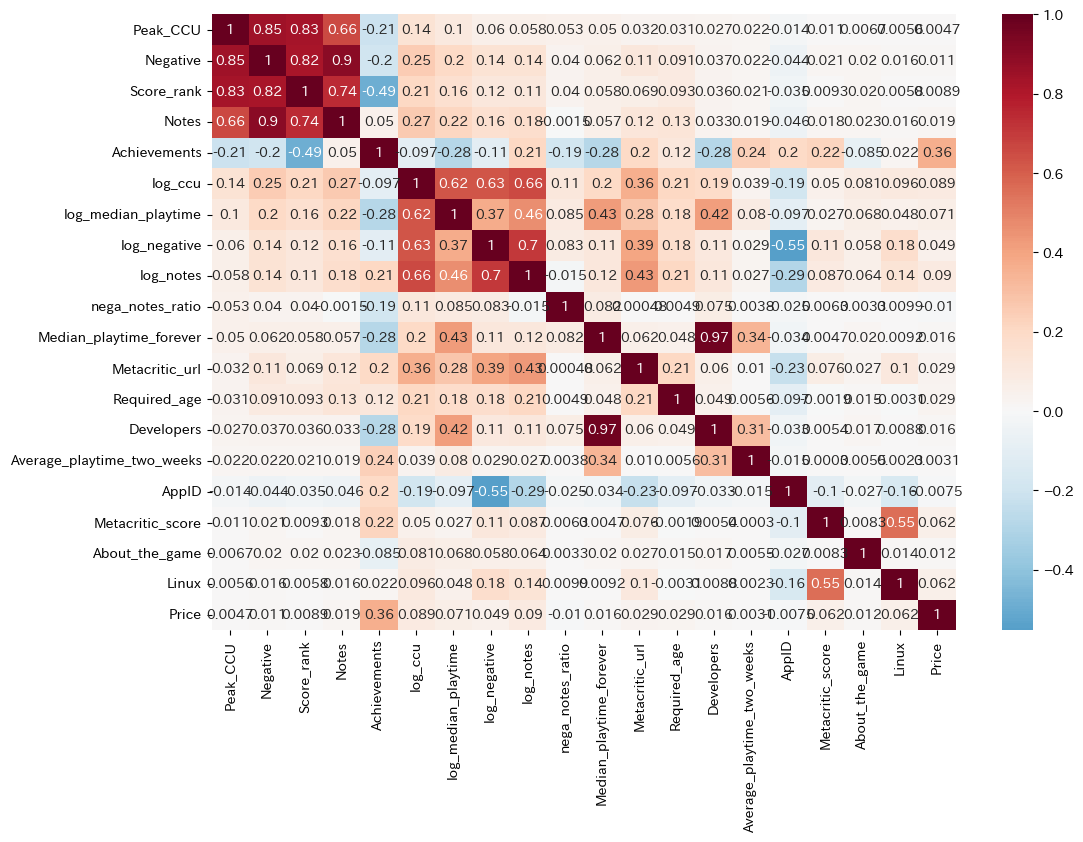

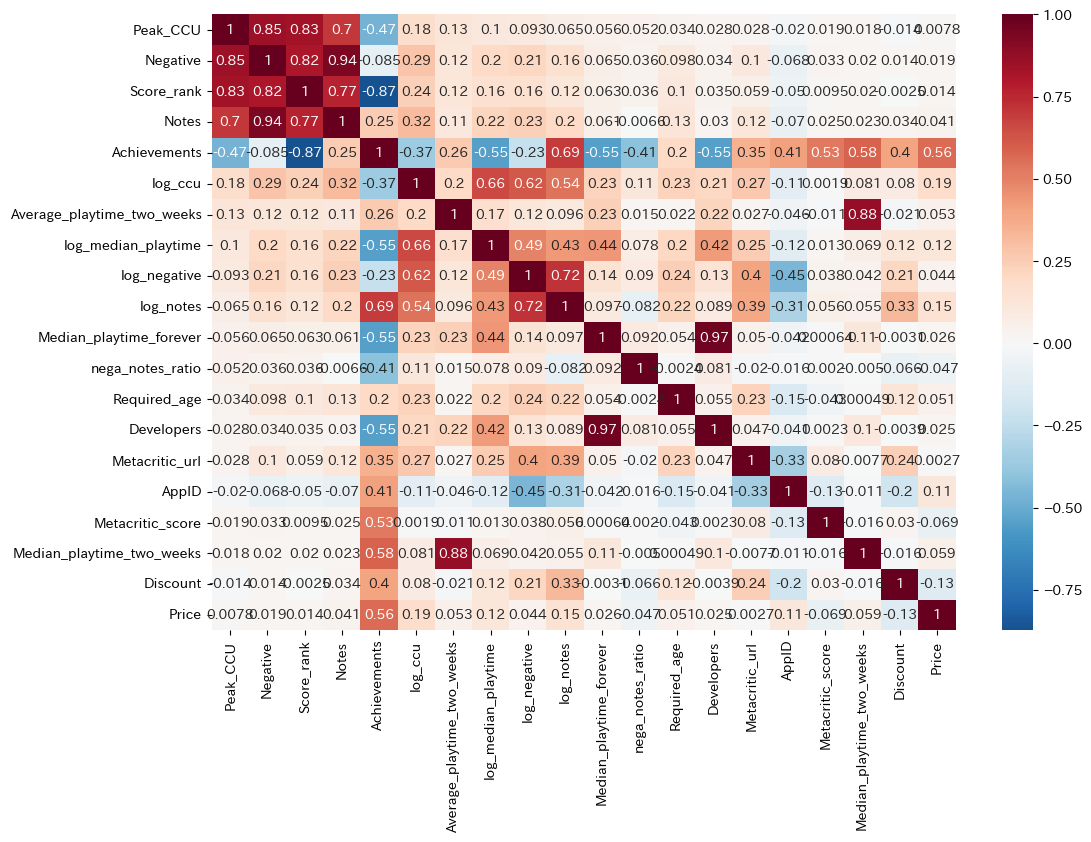

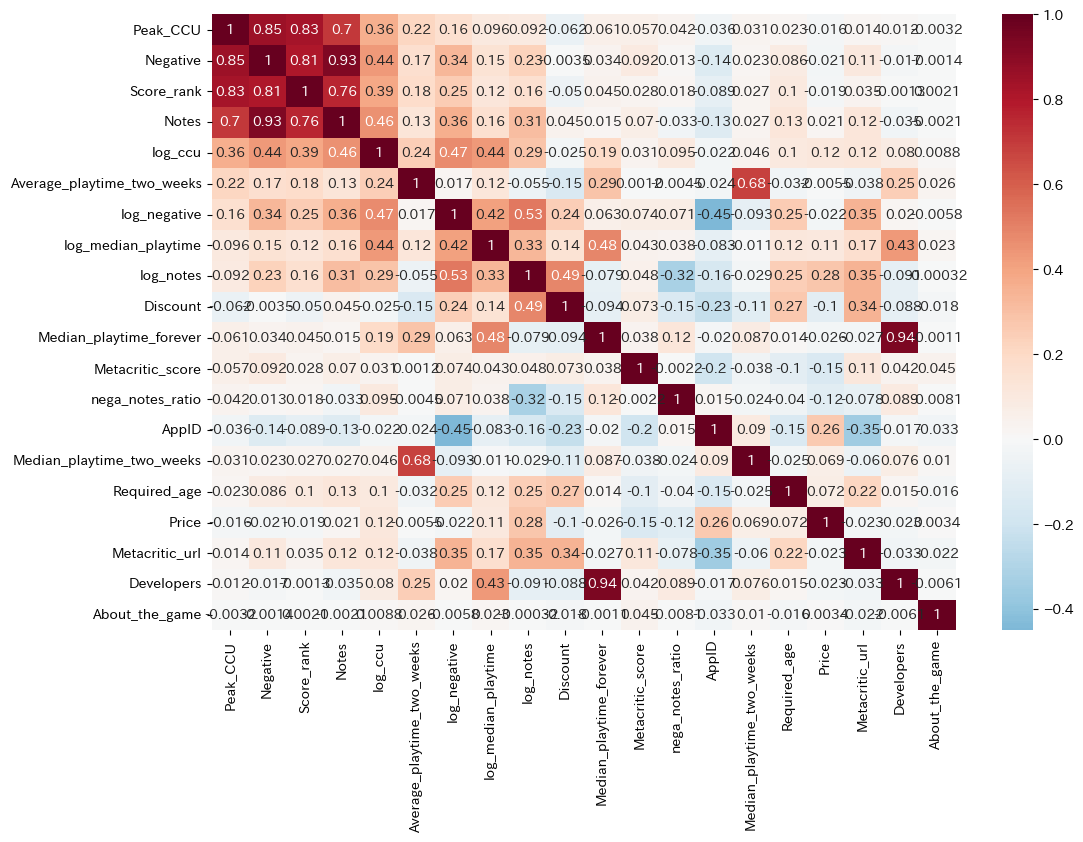

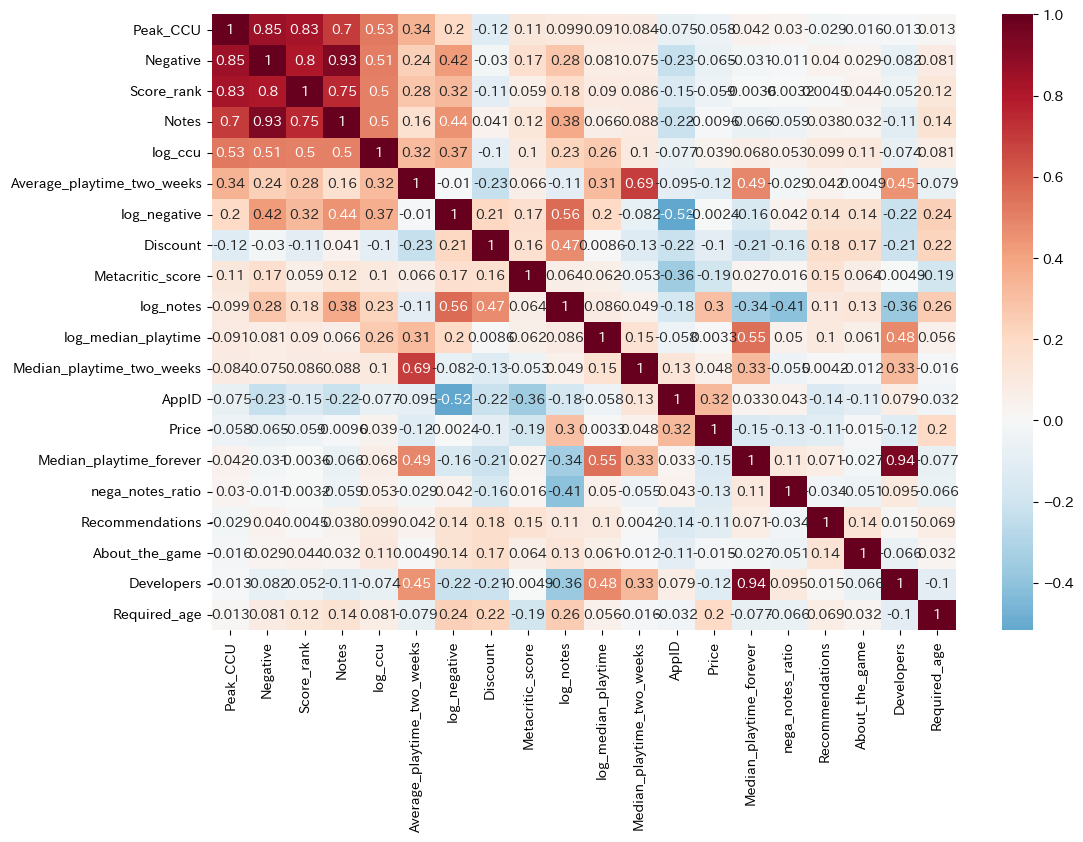

In [69]:
top_corr_cols = df.corr(numeric_only=True)['Peak_CCU'].abs().sort_values(ascending=False).head(20).index
top_corr_matrix = df[top_corr_cols].corr()

plt.figure(figsize=(12, 8))
# plt.title('すべてのデータ', size=20)  # 図のタイトル   size=は省略可能
sns.heatmap(top_corr_matrix, annot=True, cmap='RdBu_r', center=0)
plt.show()

top_corr_cols = df_active.corr(numeric_only=True)['Peak_CCU'].abs().sort_values(ascending=False).head(20).index
top_corr_matrix = df_active[top_corr_cols].corr()

plt.figure(figsize=(12, 8))
# plt.title('Peak_CCU > 0 のデータ', size=20)  # 図のタイトル   size=は省略可能
sns.heatmap(top_corr_matrix, annot=True, cmap='RdBu_r', center=0)
plt.show()

top_corr_cols = df_100.corr(numeric_only=True)['Peak_CCU'].abs().sort_values(ascending=False).head(20).index
top_corr_matrix = df_100[top_corr_cols].corr()

plt.figure(figsize=(12, 8))
# plt.title('Peak_CCU > 0 のデータ', size=20)  # 図のタイトル   size=は省略可能
sns.heatmap(top_corr_matrix, annot=True, cmap='RdBu_r', center=0)
plt.show()

top_corr_cols = df_1000.corr(numeric_only=True)['Peak_CCU'].abs().sort_values(ascending=False).head(20).index
top_corr_matrix = df_1000[top_corr_cols].corr()

plt.figure(figsize=(12, 8))
# plt.title('Peak_CCU > 0 のデータ', size=20)  # 図のタイトル   size=は省略可能
sns.heatmap(top_corr_matrix, annot=True, cmap='RdBu_r', center=0)
plt.show()

In [70]:
zero_count = (df['Peak_CCU'] == 0).sum()
print(f"同時接続ゼロのゲーム数: {zero_count} / 全体: {len(df)}")

print(f"log_ccu の最大値: {df['log_ccu'].max()}")

同時接続ゼロのゲーム数: 102935 / 全体: 122611
log_ccu の最大値: 13.829351331025592


In [71]:
formula = "Peak_CCU ~ Positive"
mod = smf.ols(formula, data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               Peak_CCU   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                  0.007804
Date:                Sun, 22 Feb 2026   Prob (F-statistic):              0.930
Time:                        16:36:54   Log-Likelihood:            -1.1823e+06
No. Observations:              122611   AIC:                         2.365e+06
Df Residuals:                  122609   BIC:                         2.365e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     54.6099     10.652      5.127      0.0

In [72]:
formula = "Peak_CCU ~ Negative"
mod = smf.ols(formula, data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               Peak_CCU   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                 3.105e+05
Date:                Sun, 22 Feb 2026   Prob (F-statistic):               0.00
Time:                        16:36:54   Log-Likelihood:            -1.1050e+06
No. Observations:              122611   AIC:                         2.210e+06
Df Residuals:                  122609   BIC:                         2.210e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -62.8724      5.671    -11.087      0.0

In [73]:
formula = "log_ccu~ log_negative"
mod = smf.ols(formula, data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                log_ccu   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                 8.016e+04
Date:                Sun, 22 Feb 2026   Prob (F-statistic):               0.00
Time:                        16:36:54   Log-Likelihood:            -1.4788e+05
No. Observations:              122611   AIC:                         2.958e+05
Df Residuals:                  122609   BIC:                         2.958e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.2841      0.003    -89.460   

In [74]:
formula = "Peak_CCU ~ Positive + Discount + Price"
mod = smf.ols(formula, data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               Peak_CCU   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.100
Date:                Sun, 22 Feb 2026   Prob (F-statistic):              0.348
Time:                        16:36:54   Log-Likelihood:            -1.1823e+06
No. Observations:              122611   AIC:                         2.365e+06
Df Residuals:                  122607   BIC:                         2.365e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     42.4738     13.366      3.178      0.0

In [75]:
# # 1. 数値データだけ取り出す or ダミー変数化
# X = pd.get_dummies(df.drop(['AppID', 'Name', 'Peak_CCU'], axis=1), drop_first=True)
# y = df['Peak_CCU']

# # 2. 標準化
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # 3. LassoCV（最適なλを自動で探してくれるモード）
# model = LassoCV(cv=5)
# model.fit(X_scaled, y)

# # 4. 生き残った変数を確認
# coeff_df = pd.DataFrame({'Feature': X.columns, 'Coef': model.coef_})
# print(coeff_df[coeff_df['Coef'] != 0])

In [76]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

def dml_scratch(Y, D, X):
    # データを2つに分ける（Cross-fittingの最小構成）
    kf = KFold(n_splits=2)
    results = []

    for train_idx, test_idx in kf.split(X):
        # 訓練データとテストデータの分割
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        D_train, D_test = D[train_idx], D[test_idx]

        # 1. モデルA: Yの予測
        model_y = RandomForestRegressor(n_estimators=100)
        model_y.fit(X_train, Y_train)
        y_res = Y_test - model_y.predict(X_test) # Yの残差

        # 2. モデルB: Dの予測
        model_d = RandomForestRegressor(n_estimators=100)
        model_d.fit(X_train, D_train)
        d_res = D_test - model_d.predict(X_test) # Dの残差

        # 3. 最後にOLS（末石本の公式）
        # y_res = beta * d_res + epsilon を解く
        ols = LinearRegression(fit_intercept=False)
        ols.fit(d_res.reshape(-1, 1), y_res)
        results.append(ols.coef_[0])

    return np.mean(results)

In [77]:
# 仮のデータ整形（Genreをダミー変数化している想定）
# Y: log_ccu, D: Price (or discount_flag), X: Genres_Action, Genres_RPG...

def estimate_cate_with_dml(df, outcome_col, treatment_col, feature_cols):
    Y = df[outcome_col].values
    D = df[treatment_col].values
    X = df[feature_cols].values
    
    kf = KFold(n_splits=2, shuffle=True, random_state=42)
    residuals_y = np.zeros(len(Y))
    residuals_d = np.zeros(len(D))
    
    # Step 1: 処置と結果の「ノイズ（背景）」をMLで予測して除去（直交化）
    for train_idx, test_idx in kf.split(X):
        # Y (CCU) の背景予測
        model_y = RandomForestRegressor(n_estimators=100, max_depth=5)
        model_y.fit(X[train_idx], Y[train_idx])
        residuals_y[test_idx] = Y[test_idx] - model_y.predict(X[test_idx])
        
        # D (Price) の背景予測
        model_d = RandomForestRegressor(n_estimators=100, max_depth=5)
        model_d.fit(X[train_idx], D[train_idx])
        residuals_d[test_idx] = D[test_idx] - model_d.predict(X[test_idx])

    # Step 2: CATEの推定
    # 残差 Y ~ CATE(X) * 残差 D という関係を利用する
    # シンプルに「残差Y / 残差D」を計算すると不安定なので、
    # 局所的な回帰や、さらにMLを使って CATE(X) を学習させる
    
    # 簡易的なCATE: 残差の比（本来はここもMLでXの関数として学習させる）
    cate_proxy = residuals_y / (residuals_d + 1e-9)
    
    return cate_proxy, residuals_y, residuals_d

# 実行イメージ
# features = [col for col in df.columns if 'Genres_' in col]
# df['cate'], res_y, res_d = estimate_cate_with_dml(df, 'log_ccu', 'Price', features)

In [78]:
# 'Genres' カラムが "Action;RPG;Indie" のような形式だと仮定
# 1. セミコロンで分割してリスト化し、explodeで縦に展開
# 2. 空白除去(strip)をしてから、unique()で重複排除
unique_genres = df['Genres'].str.split(';').explode().str.strip().unique()

# 欠損値(NaN)が含まれる場合は除外
unique_genres = [g for g in unique_genres if pd.notna(g)]

print(f"見つかったジャンル数: {len(unique_genres)}")
print(unique_genres)

見つかったジャンル数: 13291
['Single-player,Steam Trading Cards,Steam Cloud,Family Sharing', 'Single-player,Family Sharing', 'Single-player,Steam Achievements,Family Sharing', 'Single-player,VR Only,Steam Leaderboards,Family Sharing', 'Single-player,Tracked Controller Support,VR Only,Family Sharing', 'Single-player,Steam Workshop,Steam Cloud,Family Sharing', 'Single-player,Full controller support,Family Sharing', 'Single-player,Steam Achievements,Full controller support,Family Sharing', 'Single-player,Steam Achievements,Full controller support,Steam Cloud,Family Sharing,Steam Timeline', 'Single-player,Multi-player,PvP,Online PvP,Steam Achievements,Steam Trading Cards,Steam Cloud,Includes level editor,Family Sharing', 'Single-player,Steam Achievements,Partial Controller Support,Steam Cloud,Family Sharing', 'Single-player,Steam Achievements,Full controller support,Steam Cloud,Remote Play Together,Family Sharing', 'Single-player,Partial Controller Support,Family Sharing', 'Single-player,Multi-playe

In [127]:
import kagglehub
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from linearmodels import PanelOLS, RandomEffects
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
from stargazer.stargazer import Stargazer
from scipy.stats import chi2
import os

pd.options.display.float_format = '{:.2f}'.format

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from linearmodels.iv import IV2SLS

In [128]:
path = kagglehub.dataset_download("artermiloff/steam-games-dataset")

print("保存先パス:", path)

csv_path = os.path.join(path, "games_march2025_cleaned.csv")

df = pd.read_csv(csv_path, index_col=False, quotechar='"')

df = df.drop(columns=['score_rank'])

# すべての列を表示するように設定を変更
pd.set_option('display.max_columns', None)

# 元に戻したい場合はこちら
# pd.reset_option('display.max_columns')

df.head()

保存先パス: /Users/kavuk/.cache/kagglehub/datasets/artermiloff/steam-games-dataset/versions/2


appid                             name release_date  required_age  price  \
0     730                 Counter-Strike 2   2012-08-21             0   0.00   
1  578080              PUBG: BATTLEGROUNDS   2017-12-21             0   0.00   
2     570                           Dota 2   2013-07-09             0   0.00   
3  271590        Grand Theft Auto V Legacy   2015-04-13            17   0.00   
4  359550  Tom Clancy's Rainbow Six® Siege   2015-12-01            17   3.99   

   dlc_count                               detailed_description  \
0          1  For over two decades, Counter-Strike has offer...   
1          0  LAND, LOOT, SURVIVE! Play PUBG: BATTLEGROUNDS ...   
2          2  The most-played game on Steam. Every day, mill...   
3          0  When a young street hustler, a retired bank ro...   
4          9  Edition Comparison Ultimate Edition The Tom Cl...   

                                      about_the_game  \
0  For over two decades, Counter-Strike has offer...   
1  LAND, LOOT, SURVIVE! Play PUBG: BATTLEGROUNDS ...   
2  The most-played game on Steam. Every day, mill...   
3  When a young street hustler, a retired bank ro...   
4  “One of the best first-person shooters ever ma...   

                                   short_description  \
0  For over two decades, Counter-Strike has offer...   
1  Play PUBG: BATTLEGROUNDS for free. Land on str...   
2  Every day, millions of players worldwide enter...   
3  Grand Theft Auto V for PC offers players the o...   
4  Tom Clancy's Rainbow Six® Siege is an elite, t...   

                                             reviews  \
0                                                NaN   
1                                                NaN   
2  “A modern multiplayer masterpiece.” 9.5/10 – D...   
3                                                NaN   
4                                                NaN   

                                        header_image  \
0  https://shared.akamai.steamstatic.com/store_it...   
1  https://shared.akamai.steamstatic.com/store_it...   
2  https://shared.akamai.steamstatic.com/store_it...   
3  https://shared.akamai.steamstatic.com/store_it...   
4  https://shared.akamai.steamstatic.com/store_it...   

                            website                        support_url  \
0        http://counter-strike.net/                                NaN   
1              https://www.pubg.com  https://support.pubg.com/hc/en-us   
2             http://www.dota2.com/                                NaN   
3  https://www.rockstargames.com/V/  https://support.rockstargames.com   
4          http://rainbow6.ubi.com/             http://support.ubi.com   

  support_email  windows    mac  linux  metacritic_score  \
0           NaN     True  False   True                 0   
1           NaN     True  False  False                 0   
2           NaN     True   True   True                90   
3           NaN     True  False  False                96   
4           NaN     True  False  False                 0   

                                      metacritic_url  achievements  \
0                                                NaN             1   
1                                                NaN            37   
2  https://www.metacritic.com/game/pc/dota-2?ftag...             0   
3  https://www.metacritic.com/game/pc/grand-theft...            77   
4                                                NaN             0   

   recommendations                                              notes  \
0          4401572               Includes intense violence and blood.   
1          1732007                                                NaN   
2            14337  Dota 2 includes fantasy violence, use of alcoh...   
3          1803063                                                NaN   
4          1165929                                                NaN   

                                 supported_languages  \
0  ['Czech', 'Danish', 'Dutch', 'English', 'Finni.

In [80]:
print(df.columns)

Index(['appid', 'name', 'release_date', 'required_age', 'price', 'dlc_count',
       'detailed_description', 'about_the_game', 'short_description',
       'reviews', 'header_image', 'website', 'support_url', 'support_email',
       'windows', 'mac', 'linux', 'metacritic_score', 'metacritic_url',
       'achievements', 'recommendations', 'notes', 'supported_languages',
       'full_audio_languages', 'packages', 'developers', 'publishers',
       'categories', 'genres', 'screenshots', 'movies', 'user_score',
       'positive', 'negative', 'estimated_owners', 'average_playtime_forever',
       'average_playtime_2weeks', 'median_playtime_forever',
       'median_playtime_2weeks', 'discount', 'peak_ccu', 'tags',
       'pct_pos_total', 'num_reviews_total', 'pct_pos_recent',
       'num_reviews_recent'],
      dtype='object')


In [ ]:
df['posi_nega_ratio'] = df['positive'] / (df['negative'] + 1)

df['log_ccu'] = np.log(df['peak_ccu'] + 1)
df['log_positive'] = np.log(df['positive'] + 1)
df['log_negative'] = np.log(df['negative'] + 1)
df['log_median_playtime'] = np.log1p(df['median_playtime_forever'])
df['log_num_reviews_total'] = np.log1p(df['num_reviews_total'])

df['pub_id'] = pd.factorize(df['publishers'])[0]
df['main_genre'] = df['genres'].str.split(',').str[0]

df_100 = df[df['peak_ccu'] >= 100].copy()

df_1000 = df[df['peak_ccu'] >= 1000].copy()

df.sample(n=10)

/opt/anaconda3/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


appid                                          name release_date  \
44206  3055780                                      PERMUTER   2024-07-04   
60483  3373550                       なつ♡カノ SUMMER GIRLFRIEND   2024-12-25   
61047  1205690                           Defending Frontiers   2019-12-18   
66082  2714910                               Stratum Descent   2024-11-20   
45185  1767580  Twin Mind: Power of Love Collector's Edition   2021-10-22   
76990  2867230                                  Gift for You   2024-03-28   
38187   852160                            Jack the Barbarian   2018-05-21   
80192  2585970                                       Mardori   2023-09-27   
87001  3033180                          Ancient Demon Shadow   2024-08-02   
23889   993690                            Transport Services   2019-09-14   

       required_age  price  dlc_count  \
44206             0   3.99          0   
60483             0  19.99          0   
61047             0   3.99          0   
66082             0   4.99          0   
45185             0   7.99          0   
76990             0   0.99          0   
38187             0   4.99          0   
80192             0   5.99          0   
87001             0   6.99          0   
23889             0   4.99          0   

                                    detailed_description  \
44206  PERMUTER is a game inspired by the Pacifism Mo...   
60483  [SUMMER GIRLFRIEND なつ♡カノ] is a visual novel th...   
61047  Defending Frontiers-The end of human times has...   
66082  Join the Discord About the Game Stratum Descen...   
45185  When a young woman is kidnapped from a public ...   
76990  What is 'Gift for You'? This is a puzzle actio...   
38187  Jack the Barbarian is an Old-School RPG game. ...   
80192  Craft your equipment with damage or defense mo...   
87001  Ancient Demon Shadow is a game that combines s...   
23889  About this Game In transport services, you tak...   

                                          about_the_game  \
44206  PERMUTER is a game inspired by the Pacifism Mo...   
60483  [SUMMER GIRLFRIEND なつ♡カノ] is a visual novel th...   
61047  Defending Frontiers-The end of human times has...   
66082  Stratum Descent is a micro rogue-lite deck bui...   
45185  When a young woman is kidnapped from a public ...   
76990  What is 'Gift for You'? This is a puzzle actio...   
38187  Jack the Barbarian is an Old-School RPG game. ...   
80192  Craft your equipment with damage or defense mo...   
87001  Ancient Demon Shadow is a game that combines s...   
23889  About this Game In transport services, you tak...   

                                       short_description reviews  \
44206  PERMUTER is a synthwave-style autobattler insp...     NaN   
60483  Can the overly insensitive Yuichi find a girlf...     NaN   
61047  Defending Frontiers is a city defense, 2D grap...     NaN   
66082  Stratum Descent: a micro rogue-lite deck build...     NaN   
45185  Famed twin detectives go on a new case! They a...     NaN   
76990  'Gift for You' is a puzzle action game consist...     NaN   
38187  Jack the Barbarian is an Old-School RPG game. ...     NaN   
80192  Mardori is a spaceshooter game with aspects of...     NaN   
87001  Set in a vibrant and diverse otherworld, playe...     NaN   
23889  Transport services is a lightweight fast-paced...     NaN   

                                            header_image website  \
44206  https://shared.akamai.steamstatic.com/store_it...     NaN   
60483  https://shared.akamai.steamstatic.com/store_it...     NaN   
61047  https://shared.akamai.steamstatic.com/store_it...     NaN   
66082  https://shared.akamai.steamstatic.com/store_it...     NaN   
45185  https://shared.akamai.steamstatic.com/store_it...     NaN   
76990  https://shared.akamai.steamstatic.com/store_it...     NaN   
38187  https://shared.akamai.steamstatic.com/store_it...     NaN   
80192  https://shared.akamai.steamstatic.com/store_it...     NaN   
87001  https://shared.akam

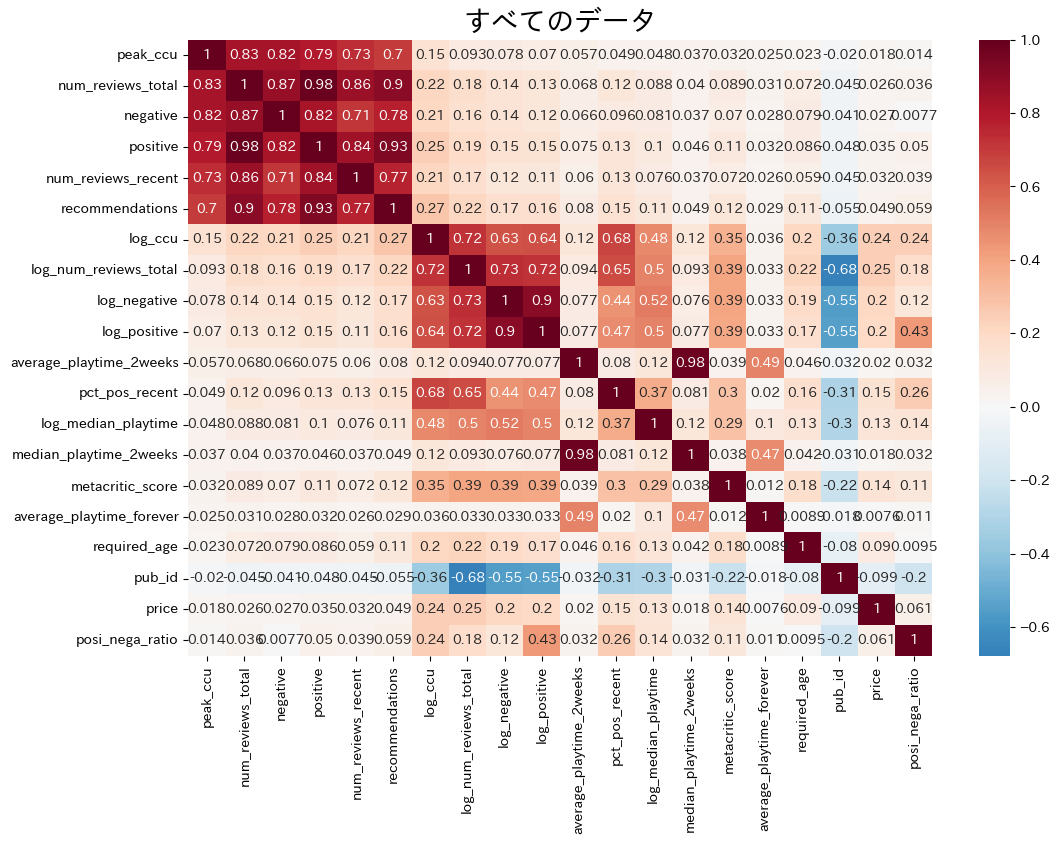

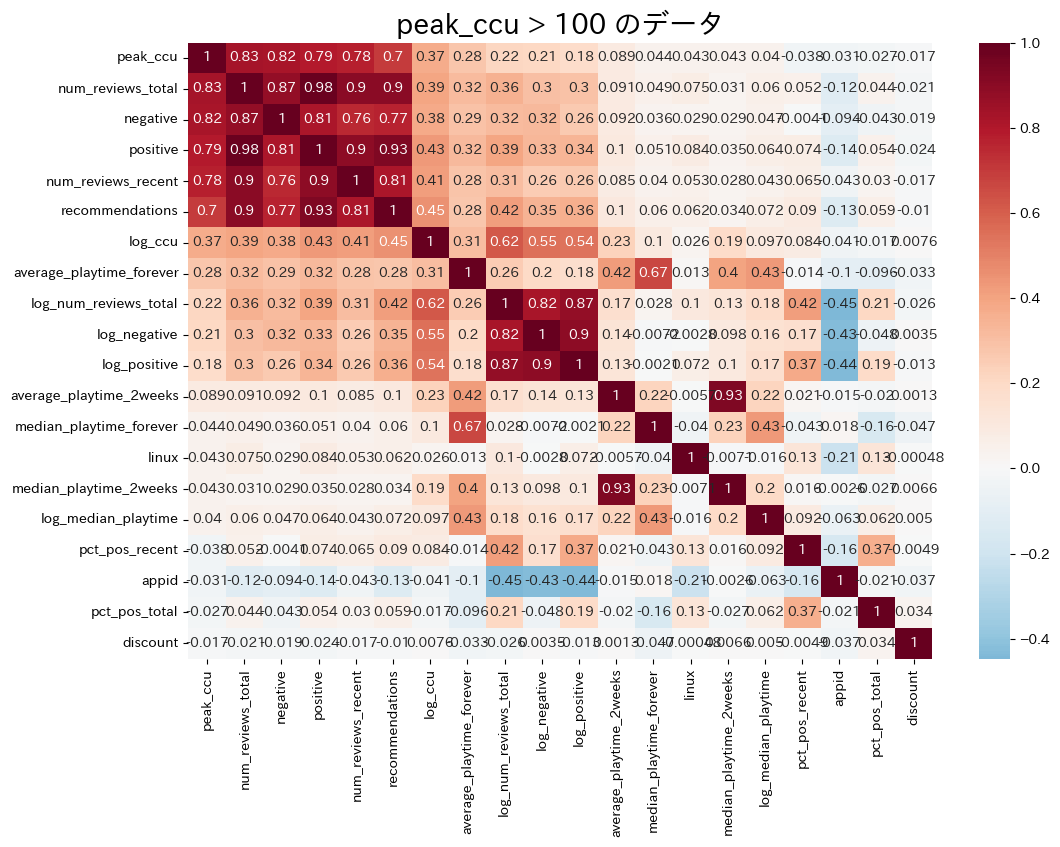

In [132]:
top_corr_cols = df.corr(numeric_only=True)['peak_ccu'].abs().sort_values(ascending=False).head(20).index
top_corr_matrix = df[top_corr_cols].corr()

plt.figure(figsize=(12, 8))
plt.title('すべてのデータ', size=20)  # 図のタイトル   size=は省略可能
sns.heatmap(top_corr_matrix, annot=True, cmap='RdBu_r', center=0)
plt.show()

top_corr_cols = df_100.corr(numeric_only=True)['peak_ccu'].abs().sort_values(ascending=False).head(20).index
top_corr_matrix = df_100[top_corr_cols].corr()

plt.figure(figsize=(12, 8))
plt.title('peak_ccu > 100 のデータ', size=20)  # 図のタイトル   size=は省略可能
sns.heatmap(top_corr_matrix, annot=True, cmap='RdBu_r', center=0)
plt.show()

# top_corr_cols = df_1000.corr(numeric_only=True)['peak_ccu'].abs().sort_values(ascending=False).head(20).index
# top_corr_matrix = df_1000[top_corr_cols].corr()

# plt.figure(figsize=(12, 8))
# plt.title('peak_ccu > 1000 のデータ', size=20)  # 図のタイトル   size=は省略可能
# sns.heatmap(top_corr_matrix, annot=True, cmap='RdBu_r', center=0)
# plt.show()

In [86]:
zero_count = (df['peak_ccu'] == 0).sum()
print(f"同時接続ゼロのゲーム数: {zero_count} / 全体: {len(df)}")

print(f"log_ccu の最大値: {df['log_ccu'].max()}")

同時接続ゼロのゲーム数: 70698 / 全体: 89618
log_ccu の最大値: 14.008076956694195


In [87]:
all_models = []
formula = "peak_ccu ~ positive"
mod = smf.ols(formula, data=df_100)
res = mod.fit()
all_models.append(res)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               peak_ccu   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     3441.
Date:                Sun, 22 Feb 2026   Prob (F-statistic):               0.00
Time:                        16:37:03   Log-Likelihood:                -23403.
No. Observations:                2042   AIC:                         4.681e+04
Df Residuals:                    2040   BIC:                         4.682e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2385.6276    520.877     -4.580      0.0

In [88]:
formula = "log_ccu ~ log_positive"
mod = smf.ols(formula, data=df_100)
res = mod.fit()
all_models.append(res)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                log_ccu   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     835.3
Date:                Sun, 22 Feb 2026   Prob (F-statistic):          3.03e-154
Time:                        16:37:03   Log-Likelihood:                -3331.8
No. Observations:                2042   AIC:                             6668.
Df Residuals:                    2040   BIC:                             6679.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.9505      0.119     24.759   

In [89]:
formula = "log_ccu ~ log_negative"
mod = smf.ols(formula, data=df_100)
res = mod.fit()
all_models.append(res)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                log_ccu   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     890.0
Date:                Sun, 22 Feb 2026   Prob (F-statistic):          1.34e-162
Time:                        16:37:03   Log-Likelihood:                -3312.6
No. Observations:                2042   AIC:                             6629.
Df Residuals:                    2040   BIC:                             6640.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.4064      0.101     33.795   

In [90]:
formula = "log_ccu ~ log_positive + log_negative"
mod = smf.ols(formula, data = df_100)
res = mod.fit()
all_models.append(res)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                log_ccu   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     467.1
Date:                Sun, 22 Feb 2026   Prob (F-statistic):          9.84e-168
Time:                        16:37:03   Log-Likelihood:                -3297.1
No. Observations:                2042   AIC:                             6600.
Df Residuals:                    2039   BIC:                             6617.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.0586      0.118     25.943   

In [91]:
print(f"現在 {len(all_models)} 個のモデルが溜まっています")
st = Stargazer(all_models)
st.custom_columns([f"Model {i+1}" for i in range(len(all_models))], [1]*len(all_models))
st

現在 4 個のモデルが溜まっています


In [92]:
df_100 = df_100.dropna(subset=['publishers'])
# 1. シンプルにユニークな名前の数を見る
print(f"ユニークなパブリッシャー数: {df_100['publishers'].nunique()}")

# 2. 出版数ランキング（被り＝同じパブリッシャーが複数のゲームを出しているか）
publisher_counts = df_100['publishers'].value_counts()
print(publisher_counts.head(20)) # 上位20社を表示

# 3. 1つしかゲームを出していないパブリッシャーがどれくらいいるか
single_game_pubs = (publisher_counts == 1).sum()
print(f"1作品しか出していないパブリッシャー数: {single_game_pubs}")

ユニークなパブリッシャー数: 1147
publishers
['Electronic Arts']               50
['Ubisoft']                       47
['SEGA']                          46
['Square Enix']                   34
['KOEI TECMO GAMES CO., LTD.']    28
['Xbox Game Studios']             27
['Bethesda Softworks']            25
['THQ Nordic']                    25
['CAPCOM Co., Ltd.']              23
['Activision']                    20
['Focus Entertainment']           18
['Paradox Interactive']           17
['2K']                            17
['Nacon']                         16
['PlayStation Publishing LLC']    16
['Deep Silver']                   14
['Bandai Namco Entertainment']    14
['Team17']                        13
['Rockstar Games']                11
['Devolver Digital']              10
Name: count, dtype: int64
1作品しか出していないパブリッシャー数: 927


In [93]:
# 1. 検定用データの作成（CCU100以上のデータを使用）
# 必要な変数に欠損値がある行をあらかじめ削除
df_hm = df_100.dropna(subset=['pub_id', 'log_ccu', 'log_positive', 'log_negative', 'price']).copy()

# パブリッシャーIDを「個体」、appidを「時間/観測単位」としてインデックス設定
# これにより linearmodels がパネル構造を認識する
df_hm = df_hm.set_index(['pub_id', 'appid'])

# 2. 固定効果モデル (Fixed Effects)
# EntityEffects=True がパブリッシャー固定効果を意味する
mod_fe = PanelOLS.from_formula("log_ccu ~ log_positive + log_negative + price + EntityEffects", data=df_hm)
res_fe = mod_fe.fit()

# 3. ランダム効果モデル (Random Effects)
mod_re = RandomEffects.from_formula("log_ccu ~ log_positive + log_negative + price", data=df_hm)
res_re = mod_re.fit()

# 4. ハウスマン検定関数の実行
def perform_hausman(fe, re):
    b_fe = fe.params
    b_re = re.params
    v_fe = fe.cov
    v_re = re.cov
    
    # 定数項以外で共通する係数を抽出
    common_idx = [i for i in b_fe.index if i in b_re.index]
    
    b_diff = np.atleast_2d(b_fe[common_idx] - b_re[common_idx])
    cov_diff = v_fe.loc[common_idx, common_idx] - v_re.loc[common_idx, common_idx]
    
    stat = abs(np.dot(np.dot(b_diff, np.linalg.inv(cov_diff)), b_diff.T).item())
    df = len(common_idx)
    p_val = 1 - chi2.cdf(stat, df)
    
    print("--- Hausman Test Results ---")
    print(f"Chi-squared statistic: {stat:.4f}")
    print(f"Degrees of freedom: {df}")
    print(f"p-value: {p_val:.4f}")
    
    if p_val < 0.05:
        print("結論: p < 0.05 なのでランダム効果モデルを棄却。固定効果モデル(FE)を採用すべきです。")
    else:
        print("結論: p >= 0.05 なのでランダム効果モデル(RE)を排除できません。")

perform_hausman(res_fe, res_re)

--- Hausman Test Results ---
Chi-squared statistic: 27.3482
Degrees of freedom: 3
p-value: 0.0000
結論: p < 0.05 なのでランダム効果モデルを棄却。固定効果モデル(FE)を採用すべきです。


In [94]:
#LSDV
model_fe = smf.ols("log_ccu ~ log_positive + price + C(pub_id) + C(main_genre)", data=df_100).fit()
print(model_fe.summary())

                            OLS Regression Results                            
Dep. Variable:                log_ccu   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     2.144
Date:                Sun, 22 Feb 2026   Prob (F-statistic):           7.18e-32
Time:                        16:37:08   Log-Likelihood:                -2296.5
No. Observations:                2042   AIC:                             6937.
Df Residuals:                     870   BIC:                         1.353e+04
Df Model:                        1171                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [95]:
def run_model(formula, data= df_100):
    mod = smf.ols(formula, data = data)
    res = mod.fit()
    all_models.append(res)
    return print(res.summary())

In [96]:
all_models = []
formula = "log_ccu ~ log_positive + log_negative"
run_model(formula)

                            OLS Regression Results                            
Dep. Variable:                log_ccu   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     467.1
Date:                Sun, 22 Feb 2026   Prob (F-statistic):          9.84e-168
Time:                        16:37:08   Log-Likelihood:                -3297.1
No. Observations:                2042   AIC:                             6600.
Df Residuals:                    2039   BIC:                             6617.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.0586      0.118     25.943   

In [97]:
formula = "log_ccu ~ log_positive + log_negative + posi_nega_ratio"
run_model(formula)

                            OLS Regression Results                            
Dep. Variable:                log_ccu   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     324.8
Date:                Sun, 22 Feb 2026   Prob (F-statistic):          2.48e-172
Time:                        16:37:08   Log-Likelihood:                -3283.3
No. Observations:                2042   AIC:                             6575.
Df Residuals:                    2038   BIC:                             6597.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.1841      0.120     

In [98]:
formula = "log_ccu ~ log_positive + log_negative + price"
run_model(formula)

                            OLS Regression Results                            
Dep. Variable:                log_ccu   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     313.9
Date:                Sun, 22 Feb 2026   Prob (F-statistic):          1.68e-167
Time:                        16:37:08   Log-Likelihood:                -3294.5
No. Observations:                2042   AIC:                             6597.
Df Residuals:                    2038   BIC:                             6619.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.0140      0.119     25.255   

In [99]:
formula = "log_ccu ~ log_positive + log_negative + price + log_median_playtime"
run_model(formula)

                            OLS Regression Results                            
Dep. Variable:                log_ccu   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     235.3
Date:                Sun, 22 Feb 2026   Prob (F-statistic):          3.23e-166
Time:                        16:37:08   Log-Likelihood:                -3294.4
No. Observations:                2042   AIC:                             6599.
Df Residuals:                    2037   BIC:                             6627.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               3.0132    

In [100]:
st = Stargazer(all_models)
st.custom_columns([f"Model {i+1}" for i in range(len(all_models))], [1]*len(all_models))
st

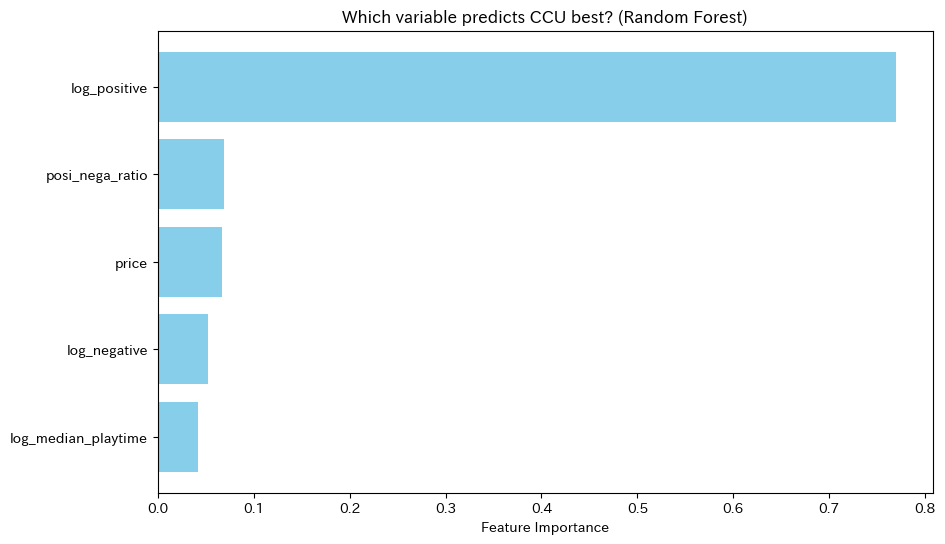

               Feature  Importance
0         log_positive        0.77
2      posi_nega_ratio        0.07
4                price        0.07
1         log_negative        0.05
3  log_median_playtime        0.04


In [119]:
# 1. 特徴量（X）と目的変数（y）の準備
# 昨日の変数をベースに、欠損値がある場合は落とす
features = ['log_positive', 'log_negative', 'posi_nega_ratio', 'log_median_playtime', 'price']
df_ml = df[features + ['log_ccu']].dropna()

X = df_ml[features]
y = df_ml['log_ccu']

# 2. モデルの構築と学習
# n_estimators: 作成する樹の数
# random_state: 結果を固定
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# 3. 特徴量の重要度（Feature Importance）の抽出
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 4. 可視化
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Which variable predicts CCU best? (Random Forest)')
plt.gca().invert_yaxis()
plt.show()

print(feature_importance_df)

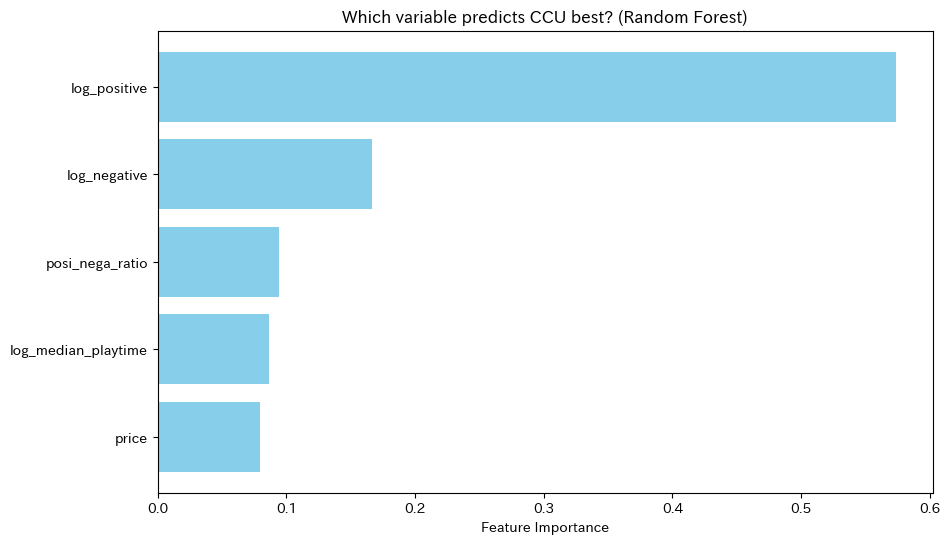

               Feature  Importance
0         log_positive        0.57
1         log_negative        0.17
2      posi_nega_ratio        0.09
3  log_median_playtime        0.09
4                price        0.08


In [115]:
# 1. 特徴量（X）と目的変数（y）の準備
# 昨日の変数をベースに、欠損値がある場合は落とす
features = ['log_positive', 'log_negative', 'posi_nega_ratio', 'log_median_playtime', 'price']
df_ml = df_100[features + ['log_ccu']].dropna()

X = df_ml[features]
y = df_ml['log_ccu']

# 2. モデルの構築と学習
# n_estimators: 作成する樹の数
# random_state: 結果を固定
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# 3. 特徴量の重要度（Feature Importance）の抽出
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 4. 可視化
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Which variable predicts CCU best? (Random Forest)')
plt.gca().invert_yaxis()
plt.show()

print(feature_importance_df)

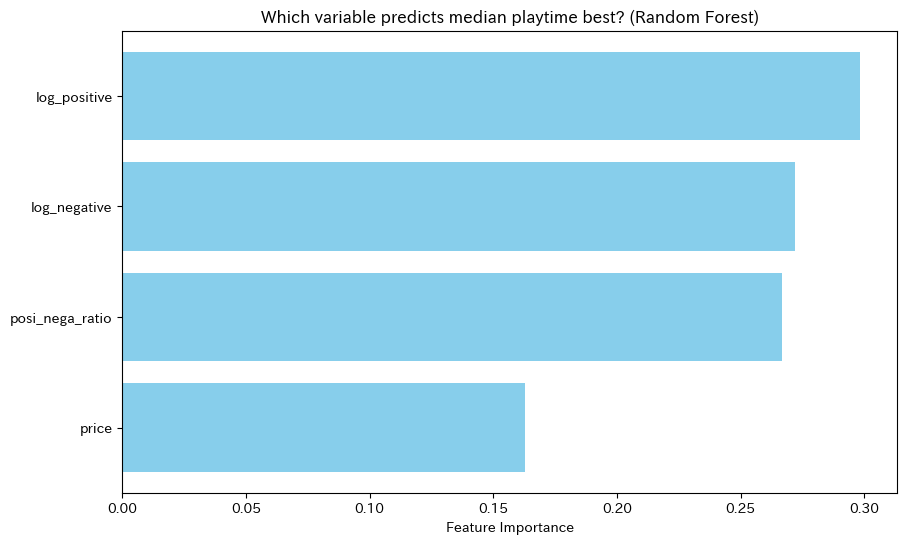

           Feature  Importance
0     log_positive        0.30
1     log_negative        0.27
2  posi_nega_ratio        0.27
3            price        0.16


In [114]:
# 1. 特徴量（X）と目的変数（y）の準備
# 昨日の変数をベースに、欠損値がある場合は落とす
features = ['log_positive', 'log_negative', 'posi_nega_ratio', 'price']
df_ml = df_100[features + ['log_median_playtime']].dropna()

X = df_ml[features]
y = df_ml['log_median_playtime']

# 2. モデルの構築と学習
# n_estimators: 作成する樹の数
# random_state: 結果を固定
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# 3. 特徴量の重要度（Feature Importance）の抽出
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 4. 可視化
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Which variable predicts median playtime best? (Random Forest)')
plt.gca().invert_yaxis()
plt.show()

print(feature_importance_df)

In [111]:
# 1. データの準備
# T: Treatment (原因), Y: Outcome (結果), X: Nuisance (邪魔な変数)
T = df_100['log_positive']
Y = df_100['log_ccu']
X = df_100[['price', 'log_median_playtime', 'log_negative']] # その他交絡因子

# --- 第1段階: Nuisance Model (力技での掃除) ---

# (a) Tの残差化: 他の変数からT(高評価数)を予測し、予測できない「純粋なT」を取り出す
model_t = RandomForestRegressor(n_estimators=100, random_state=42)
model_t.fit(X, T)
T_res = T - model_t.predict(X)

# (b) Yの残差化: 他の変数からY(CCU)を予測し、予測できない「純粋なY」を取り出す
model_y = RandomForestRegressor(n_estimators=100, random_state=42)
model_y.fit(X, Y)
Y_res = Y - model_y.predict(X)

# --- 第2段階: Causal Estimation (理論による推定) ---

# (c) 残差同士をぶつける (OLS)
# これが「直交化されたモーメント条件」を解くことに相当する
final_model = sm.OLS(Y_res, T_res).fit()

print(final_model.summary())
print(f"因果効果 (theta): {final_model.params[0]:.4f}")

                                 OLS Regression Results                                
Dep. Variable:                log_ccu   R-squared (uncentered):                   0.086
Model:                            OLS   Adj. R-squared (uncentered):              0.086
Method:                 Least Squares   F-statistic:                              193.0
Date:                Sun, 22 Feb 2026   Prob (F-statistic):                    5.52e-42
Time:                        17:52:19   Log-Likelihood:                         -1088.8
No. Observations:                2042   AIC:                                      2180.
Df Residuals:                    2041   BIC:                                      2185.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

/var/folders/wz/q14n80j54sv99s44f_fx2gmh0000gn/T/ipykernel_3006/3999606738.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"因果効果 (theta): {final_model.params[0]:.4f}")


In [113]:
# 1. データの準備
# T: Treatment (原因), Y: Outcome (結果), X: Nuisance (邪魔な変数)
T = df_100['log_negative']
Y = df_100['log_ccu']
X = df_100[['price', 'log_median_playtime', 'log_positive']] # その他交絡因子

# --- 第1段階: Nuisance Model (力技での掃除) ---

# (a) Tの残差化: 他の変数からT(高評価数)を予測し、予測できない「純粋なT」を取り出す
model_t = RandomForestRegressor(n_estimators=100, random_state=42)
model_t.fit(X, T)
T_res = T - model_t.predict(X)

# (b) Yの残差化: 他の変数からY(CCU)を予測し、予測できない「純粋なY」を取り出す
model_y = RandomForestRegressor(n_estimators=100, random_state=42)
model_y.fit(X, Y)
Y_res = Y - model_y.predict(X)

# --- 第2段階: Causal Estimation (理論による推定) ---

# (c) 残差同士をぶつける (OLS)
# これが「直交化されたモーメント条件」を解くことに相当する
final_model = sm.OLS(Y_res, T_res).fit()

print(final_model.summary())
print(f"因果効果 (theta): {final_model.params[0]:.4f}")

                                 OLS Regression Results                                
Dep. Variable:                log_ccu   R-squared (uncentered):                   0.015
Model:                            OLS   Adj. R-squared (uncentered):              0.015
Method:                 Least Squares   F-statistic:                              31.08
Date:                Sun, 22 Feb 2026   Prob (F-statistic):                    2.80e-08
Time:                        18:14:23   Log-Likelihood:                         -1079.1
No. Observations:                2042   AIC:                                      2160.
Df Residuals:                    2041   BIC:                                      2166.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

/var/folders/wz/q14n80j54sv99s44f_fx2gmh0000gn/T/ipykernel_3006/2939680452.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"因果効果 (theta): {final_model.params[0]:.4f}")


In [124]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from linearmodels.iv import IV2SLS

# 1. 前処理：CCU 100以上、かつ必要なカラムの欠損値を除去
df_iv = df_100.dropna(subset=['log_ccu', 'log_positive', 'log_positive', 'price']).copy()

# 変数の定義
Y_col = 'log_ccu'
T_col = 'log_positive'
X_cols = ['log_negative', 'log_median_playtime', 'price']
# IV候補（ラグ変数やシステム的な変数などを大量に入れる）
Z_candidates = ['log_positive'] 

# --- STEP 1: LASSOによるIVスクリーニング (Relevance Check) ---
print("Running LASSO for IV screening...")
scaler = StandardScaler()
Z_scaled = scaler.fit_transform(df_iv[Z_candidates])

# LassoCVで最適な正規化パラメータを自動選択
lasso = LassoCV(cv=5, random_state=42).fit(Z_scaled, df_iv[T_col])

# 係数が0でない変数（精鋭IV）を抽出
selected_ivs = [Z_candidates[i] for i, coef in enumerate(lasso.coef_) if coef != 0]
print(f"Selected IVs (Relevant): {selected_ivs}")

if not selected_ivs:
    raise ValueError("LASSOが全てのIV候補を削りました。候補変数を再検討してください。")

# --- STEP 2: IV-DML (Double Machine Learning with IV) ---
def get_residuals(X, target):
    model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
    model.fit(X, target)
    return target - model.predict(X)

print("Calculating residuals for DML...")
res_Y = get_residuals(df_iv[X_cols], df_iv[Y_col])
res_T = get_residuals(df_iv[X_cols], df_iv[T_col])

# 選定された各IVについて残差を計算
res_Z = pd.DataFrame({
    z: get_residuals(df_iv[X_cols], df_iv[z]) for z in selected_ivs
})

# --- STEP 3: 残差を用いた2SLS推定 ---
# 構造: Outcome(res_Y) ~ [Treatment(res_T) ~ Instruments(res_Z)]
final_iv_model = IV2SLS(res_Y, None, res_T, res_Z).fit()

print("\n--- IV-DML Results ---")
print(final_iv_model.summary)

# J検定（過剰識別制約検定）の確認
if len(selected_ivs) > 1:
    print(f"\nSargan-Hansen J-test p-value: {final_iv_model.sargan.pvalue:.4f}")

Running LASSO for IV screening...
Selected IVs (Relevant): ['log_positive']
Calculating residuals for DML...

--- IV-DML Results ---
                          IV-2SLS Estimation Summary                          
Dep. Variable:                log_ccu   R-squared:                      0.0759
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0755
No. Observations:                2042   F-statistic:                    134.46
Date:                Sun, Feb 22 2026   P-value (F-stat)                0.0000
Time:                        18:42:44   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                               
              Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------

In [126]:
path = kagglehub.dataset_download("artermiloff/steam-games-dataset")

print("保存先パス:", path)

csv_path_2024 = os.path.join(path, "games_may2024_cleaned.csv")

df_2024 = pd.read_csv(csv_path_2024, index_col=False, quotechar='"')

df_2024 = df_2024.drop(columns=['score_rank'])

df_2024.head()

保存先パス: /Users/kavuk/.cache/kagglehub/datasets/artermiloff/steam-games-dataset/versions/2


AppID                             name release_date  required_age  price  \
0     730                 Counter-Strike 2   2012-08-21             0   0.00   
1  578080              PUBG: BATTLEGROUNDS   2017-12-21             0   0.00   
2     570                           Dota 2   2013-07-09             0   0.00   
3  271590               Grand Theft Auto V   2015-04-13            17   0.00   
4  359550  Tom Clancy's Rainbow Six® Siege   2015-12-01            17  19.99   

   dlc_count                               detailed_description  \
0          1  For over two decades, Counter-Strike has offer...   
1          0  LAND, LOOT, SURVIVE! Play PUBG: BATTLEGROUNDS ...   
2          2  The most-played game on Steam. Every day, mill...   
3          1  When a young street hustler, a retired bank ro...   
4          9  Edition Comparison Ultimate Edition The Tom Cl...   

                                      about_the_game  \
0  For over two decades, Counter-Strike has offer...   
1  LAND, LOOT, SURVIVE! Play PUBG: BATTLEGROUNDS ...   
2  The most-played game on Steam. Every day, mill...   
3  When a young street hustler, a retired bank ro...   
4  “One of the best first-person shooters ever ma...   

                                   short_description  \
0  For over two decades, Counter-Strike has offer...   
1  Play PUBG: BATTLEGROUNDS for free. Land on str...   
2  Every day, millions of players worldwide enter...   
3  Grand Theft Auto V for PC offers players the o...   
4  Tom Clancy's Rainbow Six® Siege is an elite, t...   

                                             reviews  \
0                                                NaN   
1                                                NaN   
2  “A modern multiplayer masterpiece.” 9.5/10 – D...   
3                                                NaN   
4                                                NaN   

                                        header_image  \
0  https://cdn.akamai.steamstatic.com/steam/apps/...   
1  https://cdn.akamai.steamstatic.com/steam/apps/...   
2  https://cdn.akamai.steamstatic.com/steam/apps/...   
3  https://shared.akamai.steamstatic.com/store_it...   
4  https://cdn.akamai.steamstatic.com/steam/apps/...   

                           website                            support_url  \
0       http://counter-strike.net/                                    NaN   
1             https://www.pubg.com  https://support.playbattlegrounds.com   
2            http://www.dota2.com/                                    NaN   
3  http://www.rockstargames.com/V/      https://support.rockstargames.com   
4         http://rainbow6.ubi.com/                 http://support.ubi.com   

  support_email  windows    mac  linux  metacritic_score  \
0           NaN     True  False   True                 0   
1           NaN     True  False  False                 0   
2           NaN     True   True   True                90   
3           NaN     True  False  False                96   
4           NaN     True  False  False                 0   

                                      metacritic_url  achievements  \
0                                                NaN             1   
1                                                NaN            37   
2  https://www.metacritic.com/game/pc/dota-2?ftag...             0   
3  https://www.metacritic.com/game/pc/grand-theft...            77   
4                                                NaN             0   

   recommendations                                 notes  \
0          4111974  Includes intense violence and blood.   
1          1701431                                   NaN   
2            14329                                   NaN   
3          1641404                                   NaN   
4          1088708                                   NaN   

                                 supported_languages  \
0  ['Czech', 'Danish', 'Dutch', 'English', 'Finni...   
1  ['English', 'Korean', 'Simplified Chinese', 'F...  

In [139]:
# --- 1. 2024年データの整形 ---
# 2026年側のデータと重複しないよう、必要な列だけ抽出して名前を変える
# AppIDは結合キー、Positiveは1期前のIV候補として使用
df_2024_subset = df_2024[['AppID', 'positive']].copy()
df_2024_subset = df_2024_subset.rename(columns={'positive': 'lag_positive', 'AppID': 'appid'})

# --- 2. 2026年データとAppIDで結合 (Self-Merge) ---
# df_2026 は現在あなたが分析に使っている最新のデータフレーム
df_panel = pd.merge(df, df_2024_subset, on='appid', how='inner')

# CCU100以上の絞り込みと対数変換（すでに済んでいる場合はスキップ）
df_panel = df_panel[df_panel['peak_ccu'] >= 100].copy()
df_panel['log_lag_positive'] = np.log1p(df_panel['lag_positive'])

# --- 3. LASSOによるIVスクリーニング ---
# ここで 'log_positive' (2026年) を Z_candidates から外すのが鉄則
Z_candidates = ['log_lag_positive', 'num_reviews_total'] 
print(f"現在、LASSOに投入するIV候補: {Z_candidates}")
T_col = 'log_positive'
Y_col = 'log_ccu'
X_cols = ['price', 'log_negative', 'log_median_playtime']

print("Running LASSO on lagged instruments...")
scaler = StandardScaler()
Z_scaled = scaler.fit_transform(df_panel[Z_candidates])
lasso = LassoCV(cv=5, random_state=42).fit(Z_scaled, df_panel[T_col])

selected_ivs = [Z_candidates[i] for i, coef in enumerate(lasso.coef_) if coef != 0]
print(f"Selected IVs: {selected_ivs}")

# --- 4. IV-DML 実行 ---
def get_residuals(X, target):
    model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
    model.fit(X, target)
    return target - model.predict(X)

res_Y = get_residuals(df_panel[X_cols], df_panel[Y_col])
res_T = get_residuals(df_panel[X_cols], df_panel[T_col])
res_Z = pd.DataFrame({z: get_residuals(df_panel[X_cols], df_panel[z]) for z in selected_ivs})

# 2SLS推定
final_iv_dml = IV2SLS(res_Y, None, res_T, res_Z).fit()
print(final_iv_dml.summary)

現在、LASSOに投入するIV候補: ['log_lag_positive', 'num_reviews_total']
Running LASSO on lagged instruments...
Selected IVs: ['log_lag_positive', 'num_reviews_total']
                          IV-2SLS Estimation Summary                          
Dep. Variable:                log_ccu   R-squared:                      0.1211
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1206
No. Observations:                1763   F-statistic:                    118.41
Date:                Mon, Feb 23 2026   P-value (F-stat)                0.0000
Time:                        18:59:13   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                               
              Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------